# FAISS Example 06: Real-World Applications
# Ví dụ 6: Ứng dụng Thực tế với Visualization

Notebook này minh họa:
- **Product Recommendation System** (E-commerce)
- **Document Semantic Search**
- **User-based Recommendations**
- Practical patterns và best practices
- Performance optimization cho production

In [1]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import time
from typing import List, Dict, Tuple
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import sys
import os

sys.path.append(os.path.dirname(os.path.abspath('')))
from utils.data_generator import generate_text_like_embeddings, normalize_vectors
from utils.benchmark import benchmark_index, print_index_info

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports hoàn tất!")

✓ Imports hoàn tất!


## Use Case 1: Product Recommendation System

### Scenario:
E-commerce platform với 50K sản phẩm. User đang xem một sản phẩm, cần recommend các sản phẩm tương tự.

### Solution:
- Embeddings từ product images/descriptions (CLIP, ResNet, BERT, etc.)
- FAISS index để tìm similar products
- Real-time recommendations với low latency

In [2]:
# Simulate product database
print("Creating Product Database...\n")

n_products = 50000
embedding_dim = 256  # Typical for CLIP, ResNet
n_categories = 20    # Electronics, Clothing, Home, etc.

# Categories
category_names = [
    "Electronics", "Clothing", "Home & Kitchen", "Books", "Sports",
    "Toys", "Beauty", "Automotive", "Food", "Pet Supplies",
    "Health", "Garden", "Office", "Music", "Movies",
    "Baby", "Jewelry", "Shoes", "Watches", "Arts & Crafts"
]

# Generate product metadata
np.random.seed(42)
products_df = pd.DataFrame({
    'product_id': range(n_products),
    'category': np.random.choice(category_names, n_products),
    'price': np.random.lognormal(4, 1.5, n_products),
    'rating': np.random.beta(8, 2, n_products) * 5,  # Skewed toward high ratings
    'popularity': np.random.zipf(1.5, n_products)    # Power law distribution
})

# Generate embeddings (simulating CLIP or similar model)
print("Generating product embeddings...")
product_embeddings = generate_text_like_embeddings(
    n_products, 
    dimension=embedding_dim,
    n_topics=n_categories
)

# Normalize for cosine similarity
product_embeddings = normalize_vectors(product_embeddings)

print(f"\n✓ Created {n_products:,} products")
print(f"✓ Embedding dimension: {embedding_dim}")
print(f"✓ Categories: {n_categories}")
print(f"\nSample products:")
print(products_df.head(10))

Creating Product Database...

Generating product embeddings...

✓ Created 50,000 products
✓ Embedding dimension: 256
✓ Categories: 20

Sample products:
   product_id       category       price    rating  popularity
0           0         Beauty    1.052859  4.892960           1
1           1  Arts & Crafts  103.433493  4.663536           1
2           2         Movies   86.102071  4.642473           6
3           3         Health  396.833767  4.898630           3
4           4     Automotive  111.183389  3.727410        1106
5           5         Beauty    1.092644  4.331739           4
6           6        Watches   19.048101  3.222009           2
7           7         Health   21.233478  3.030223           1
8           8         Health  117.571165  4.413639           1
9           9          Books    1.020992  4.130704           2


## Visualize Product Embeddings Space

Reducing dimensions for visualization...
✓ PCA explained variance: 1.51%


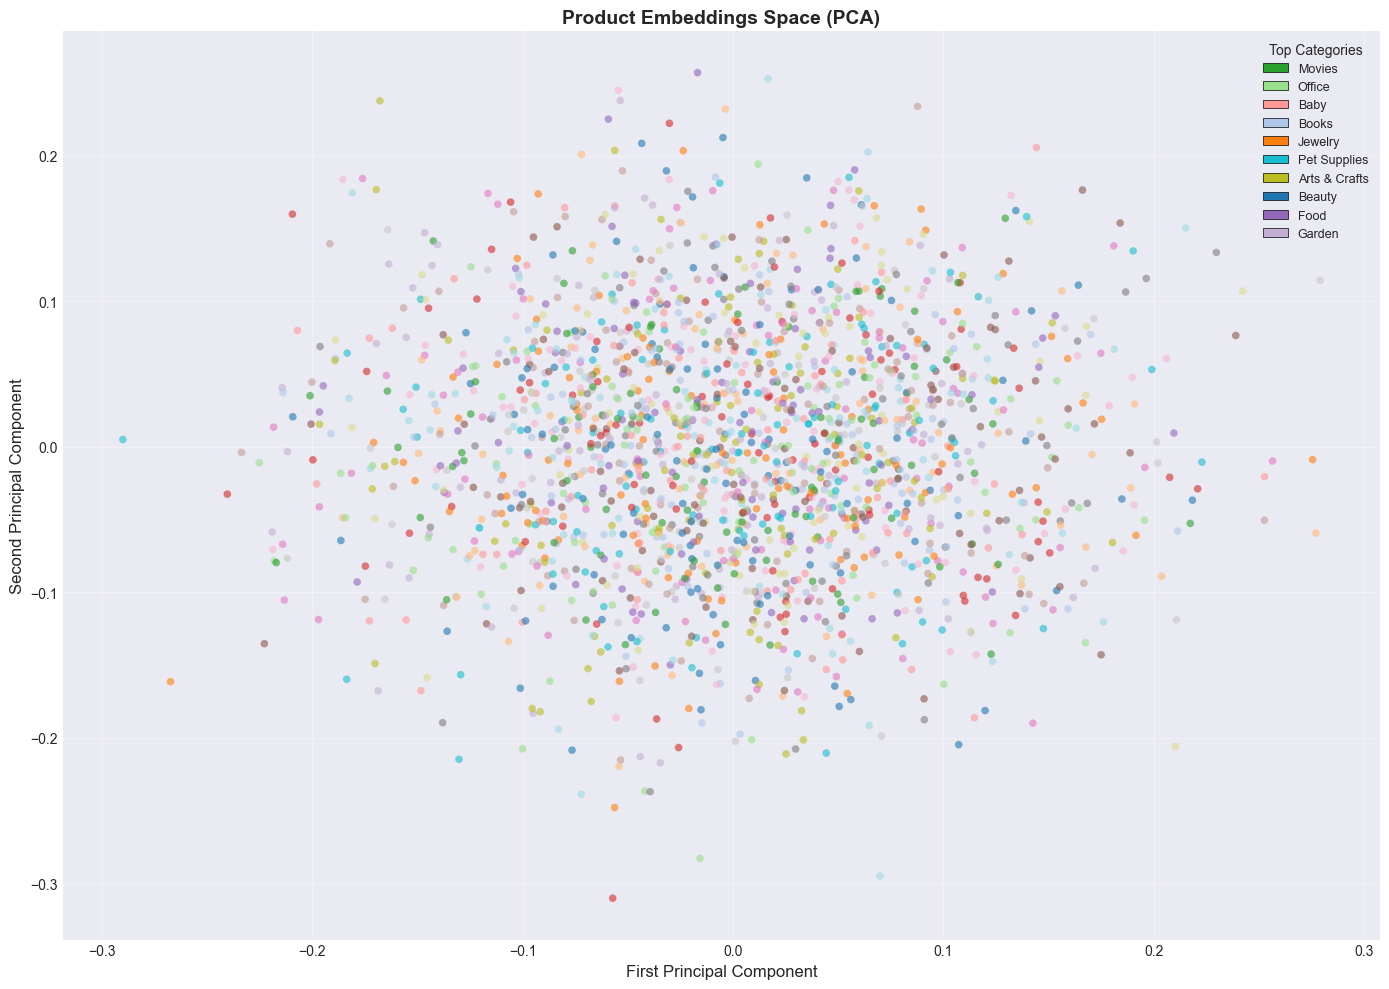

✓ Đã lưu: 06_product_embeddings.png


In [5]:
# Visualize embeddings in 2D
print("Reducing dimensions for visualization...")

# Sample for visualization
n_sample = 2000
sample_idx = np.random.choice(n_products, n_sample, replace=False)
sample_embeddings = product_embeddings[sample_idx]
sample_categories = products_df.iloc[sample_idx]['category'].values

# PCA for quick 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sample_embeddings)

print(f"✓ PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

# Color by category
unique_cats = list(set(sample_categories))
cat_colors = {cat: i for i, cat in enumerate(unique_cats)}
colors = [cat_colors[cat] for cat in sample_categories]

scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=colors, cmap='tab20', alpha=0.6, s=30, edgecolors='none')

ax.set_xlabel('First Principal Component', fontsize=12)
ax.set_ylabel('Second Principal Component', fontsize=12)
ax.set_title('Product Embeddings Space (PCA)', fontsize=14, fontweight='bold')

# Legend with top 10 categories - Fixed version
from matplotlib.patches import Patch
top_cats = products_df['category'].value_counts().head(10).index
legend_elements = []
for cat in top_cats:
    if cat in unique_cats:
        color_value = cat_colors[cat] / len(unique_cats)
        # Get the color from the colormap
        color = plt.cm.tab20(color_value)
        legend_elements.append(Patch(facecolor=color, edgecolor='black', 
                                     linewidth=0.5, label=cat))

ax.legend(handles=legend_elements, loc='best', fontsize=9, title='Top Categories',
          framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_product_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 06_product_embeddings.png")

## Build Product Index

In [4]:
# Build FAISS index for products
print("Building FAISS index for products...\n")

# For cosine similarity, use IndexFlatIP (Inner Product)
# Vectors are already normalized

# Choose index based on size
if n_products < 100000:
    print("Using HNSW for high accuracy + speed")
    index = faiss.IndexHNSWFlat(embedding_dim, 32)
    index.hnsw.efConstruction = 40
    
    start = time.time()
    index.add(product_embeddings)
    build_time = time.time() - start
    
    index.hnsw.efSearch = 32
    index_type = "HNSW"
else:
    print("Using IVF+PQ for large scale")
    nlist = int(np.sqrt(n_products))
    m = 32
    quantizer = faiss.IndexFlatIP(embedding_dim)
    index = faiss.IndexIVFPQ(quantizer, embedding_dim, nlist, m, 8)
    
    start = time.time()
    index.train(product_embeddings)
    index.add(product_embeddings)
    build_time = time.time() - start
    
    index.nprobe = 10
    index_type = "IVF+PQ"

print(f"\n✓ Built {index_type} index in {build_time:.3f}s")
print_index_info(index, f"{index_type} Product Index")

Building FAISS index for products...

Using HNSW for high accuracy + speed

✓ Built HNSW index in 6.883s

HNSW Product Index Information:
  Type: IndexHNSWFlat
  Dimension: 256
  Total vectors: 50000
  Is trained: True
  Metric type: 1
  Memory size: 61.81 MB
  HNSW M: 3


## Product Recommendation Demo

In [6]:
def recommend_products(product_id: int, k: int = 10) -> pd.DataFrame:
    """Recommend similar products"""
    
    # Get product embedding
    query_embedding = product_embeddings[product_id:product_id+1]
    
    # Search (k+1 because first result is the product itself)
    distances, indices = index.search(query_embedding, k + 1)
    
    # Remove the query product itself
    indices = indices[0][1:]
    distances = distances[0][1:]
    
    # Get product info
    recommendations = products_df.iloc[indices].copy()
    recommendations['similarity'] = distances  # Cosine similarity (1 = identical)
    
    return recommendations

# Demo: Recommend for a random product
query_product_id = np.random.randint(0, n_products)
query_product = products_df.iloc[query_product_id]

print("="*70)
print("PRODUCT RECOMMENDATION DEMO")
print("="*70)

print(f"\nUser is viewing:")
print(f"  Product ID: {query_product['product_id']}")
print(f"  Category: {query_product['category']}")
print(f"  Price: ${query_product['price']:.2f}")
print(f"  Rating: {query_product['rating']:.1f}/5.0")

# Get recommendations
start = time.time()
recommendations = recommend_products(query_product_id, k=10)
search_time = time.time() - start

print(f"\n📦 Top 10 Recommended Products (found in {search_time*1000:.2f}ms):")
print("="*70)
print(recommendations[['product_id', 'category', 'price', 'rating', 'similarity']].to_string(index=False))

# Analyze recommendations
same_category = (recommendations['category'] == query_product['category']).sum()
print(f"\n📊 Analysis:")
print(f"  Same category: {same_category}/10")
print(f"  Avg similarity: {recommendations['similarity'].mean():.3f}")
print(f"  Search latency: {search_time*1000:.2f}ms")

PRODUCT RECOMMENDATION DEMO

User is viewing:
  Product ID: 46386
  Category: Books
  Price: $23.17
  Rating: 4.2/5.0

📦 Top 10 Recommended Products (found in 8.22ms):
 product_id       category      price   rating  similarity
      36575         Sports  45.417655 4.315031    1.491379
      15780           Food 108.245234 2.322713    1.498161
      46832 Home & Kitchen  20.387463 3.906252    1.510514
      34742           Toys  50.304716 3.765829    1.524308
       1268 Home & Kitchen 273.732618 4.314785    1.524923
      15356  Arts & Crafts 216.117911 3.230052    1.525607
       9870         Beauty 278.147211 4.540130    1.527456
      32158         Sports 359.798553 4.626832    1.530960
      42562        Jewelry 109.577423 3.402589    1.535650
      42699         Office  11.098791 2.394443    1.537614

📊 Analysis:
  Same category: 0/10
  Avg similarity: 1.521
  Search latency: 8.22ms


## Visualize Recommendations

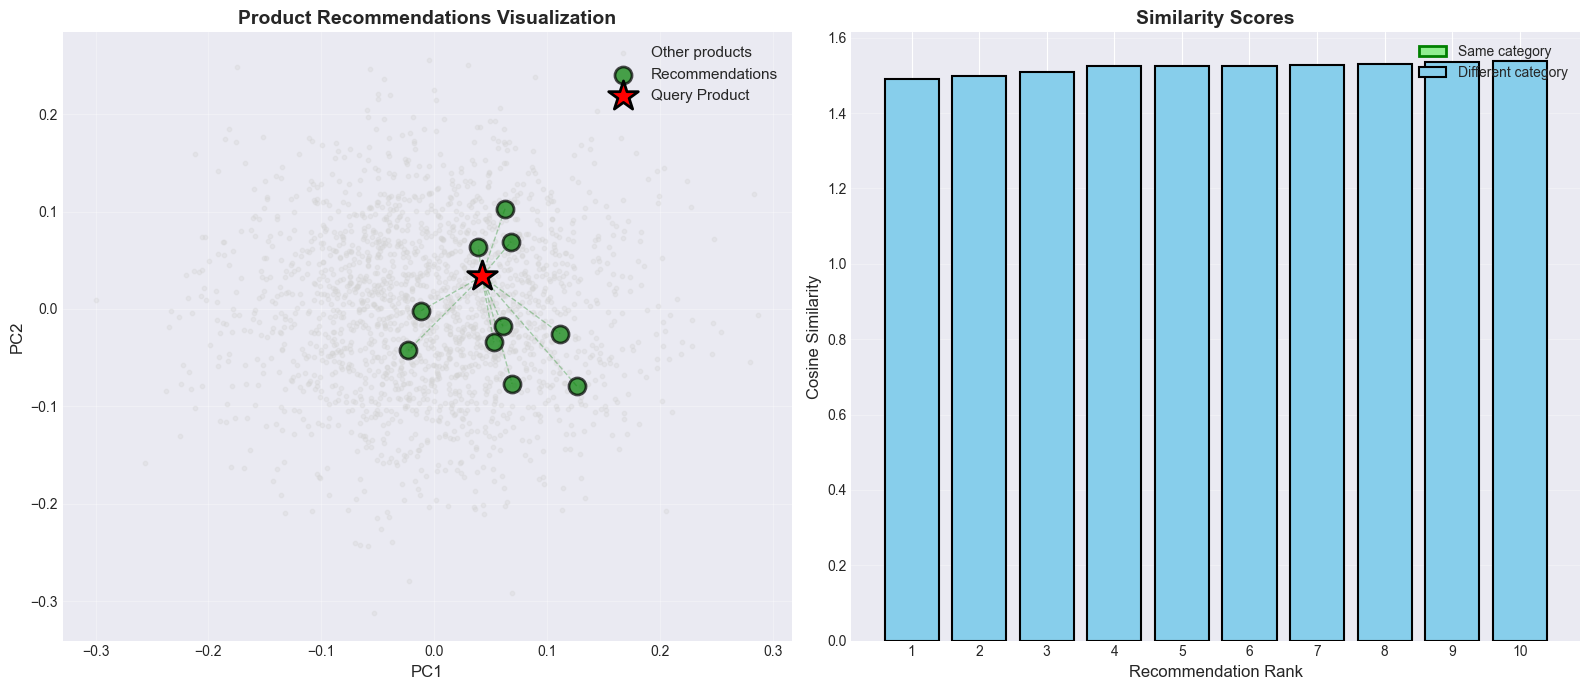

✓ Đã lưu: 06_recommendation_visualization.png


In [7]:
# Visualize query product and recommendations in 2D
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Get embeddings for query and recommendations
query_emb = product_embeddings[query_product_id]
rec_ids = recommendations['product_id'].values
rec_embs = product_embeddings[rec_ids]

# Combine with sample for context
all_embs = np.vstack([sample_embeddings, query_emb.reshape(1, -1), rec_embs])
all_2d = pca.transform(all_embs)

sample_2d = all_2d[:len(sample_embeddings)]
query_2d = all_2d[len(sample_embeddings)]
rec_2d = all_2d[len(sample_embeddings)+1:]

# Plot 1: Overview
ax = axes[0]
ax.scatter(sample_2d[:, 0], sample_2d[:, 1], 
           c='lightgray', alpha=0.3, s=10, label='Other products')
ax.scatter(rec_2d[:, 0], rec_2d[:, 1],
           c='green', s=150, alpha=0.7, edgecolors='black',
           linewidth=2, label='Recommendations', zorder=4)
ax.scatter(query_2d[0], query_2d[1],
           c='red', marker='*', s=500, edgecolors='black',
           linewidth=2, label='Query Product', zorder=5)

# Draw lines
for rec in rec_2d:
    ax.plot([query_2d[0], rec[0]], [query_2d[1], rec[1]],
            'g--', alpha=0.3, linewidth=1)

ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_title('Product Recommendations Visualization', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Similarity distribution
ax = axes[1]
similarities = recommendations['similarity'].values
ranks = np.arange(1, len(similarities) + 1)

bars = ax.bar(ranks, similarities, color='skyblue', edgecolor='black', linewidth=1.5)
ax.set_xlabel('Recommendation Rank', fontsize=12)
ax.set_ylabel('Cosine Similarity', fontsize=12)
ax.set_title('Similarity Scores', fontsize=14, fontweight='bold')
ax.set_xticks(ranks)
ax.grid(True, alpha=0.3, axis='y')

# Color code same category
for i, bar in enumerate(bars):
    if recommendations.iloc[i]['category'] == query_product['category']:
        bar.set_color('lightgreen')
        bar.set_edgecolor('green')
        bar.set_linewidth(2)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='green', linewidth=2, label='Same category'),
    Patch(facecolor='skyblue', edgecolor='black', linewidth=1.5, label='Different category')
]
ax.legend(handles=legend_elements, fontsize=10)

plt.tight_layout()
plt.savefig('06_recommendation_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 06_recommendation_visualization.png")

## Use Case 2: Batch Recommendations (User Behavior)

In [8]:
# Simulate user viewing history
print("="*70)
print("USE CASE 2: User-based Recommendations")
print("="*70)

print("\nScenario: User has viewed multiple products, recommend based on browsing history")

# Simulate user history
n_viewed = 5
viewed_products = np.random.choice(n_products, n_viewed, replace=False)

print(f"\nUser's browsing history ({n_viewed} products):")
for idx in viewed_products:
    p = products_df.iloc[idx]
    print(f"  #{idx}: {p['category']}, ${p['price']:.2f}, Rating: {p['rating']:.1f}")

# Aggregate strategy: Average embeddings
viewed_embeddings = product_embeddings[viewed_products]
user_profile_embedding = viewed_embeddings.mean(axis=0, keepdims=True)
user_profile_embedding = normalize_vectors(user_profile_embedding)

# Search
distances, indices = index.search(user_profile_embedding, 20)

# Filter out already viewed products
indices = indices[0]
distances = distances[0]
mask = ~np.isin(indices, viewed_products)
indices = indices[mask][:10]
distances = distances[mask][:10]

user_recommendations = products_df.iloc[indices].copy()
user_recommendations['similarity'] = distances

print(f"\n📦 Recommended Products based on User Profile:")
print(user_recommendations[['product_id', 'category', 'price', 'rating', 'similarity']].to_string(index=False))

# Category analysis
viewed_categories = products_df.iloc[viewed_products]['category'].value_counts()
rec_categories = user_recommendations['category'].value_counts()

print(f"\n📊 Category Distribution:")
print(f"  Viewed: {dict(viewed_categories)}")
print(f"  Recommended: {dict(rec_categories)}")

USE CASE 2: User-based Recommendations

Scenario: User has viewed multiple products, recommend based on browsing history

User's browsing history (5 products):
  #18888: Electronics, $25.49, Rating: 4.7
  #12308: Baby, $97.87, Rating: 4.9
  #42703: Watches, $34.50, Rating: 4.4
  #47300: Shoes, $258.49, Rating: 4.0
  #27240: Home & Kitchen, $172.14, Rating: 4.3

📦 Recommended Products based on User Profile:
 product_id    category      price   rating  similarity
      20390 Electronics 232.828423 4.125530    1.492894
      31991      Garden 345.810690 2.443569    1.498408
       7232      Beauty  54.290345 2.998190    1.503429
       3888        Food  94.372209 3.113027    1.509758
      20829    Clothing  24.884317 3.036482    1.517576
      20991        Baby  65.796357 4.343443    1.520102
      11434       Shoes  30.911474 2.826638    1.521869
       7472     Watches  11.461994 4.508421    1.527361
      26365      Office  10.496439 4.675034    1.533145
      11458     Jewelry  16.62

## Performance Analysis for Production

In [9]:
# Benchmark for production readiness
print("="*70)
print("PRODUCTION PERFORMANCE ANALYSIS")
print("="*70)

# Test with different batch sizes
batch_sizes = [1, 10, 50, 100, 500]
latencies = []
throughputs = []

print(f"\nBenchmarking with different batch sizes...\n")
print(f"{'Batch Size':<12} {'Avg Latency':<15} {'Throughput':<15} {'P95 Latency':<15}")
print("-" * 60)

for batch_size in batch_sizes:
    # Generate random queries
    test_queries = product_embeddings[np.random.choice(n_products, batch_size)]
    
    # Warmup
    index.search(test_queries[:min(5, batch_size)], 10)
    
    # Benchmark
    times = []
    for _ in range(20):  # 20 iterations
        start = time.time()
        index.search(test_queries, 10)
        times.append(time.time() - start)
    
    avg_time = np.mean(times)
    p95_time = np.percentile(times, 95)
    throughput = batch_size / avg_time
    
    latencies.append(avg_time / batch_size * 1000)  # ms per query
    throughputs.append(throughput)
    
    print(f"{batch_size:<12} {avg_time/batch_size*1000:<15.3f} {throughput:<15.1f} {p95_time/batch_size*1000:<15.3f}")

print(f"\n✓ Benchmark complete")

PRODUCTION PERFORMANCE ANALYSIS

Benchmarking with different batch sizes...

Batch Size   Avg Latency     Throughput      P95 Latency    
------------------------------------------------------------
1            0.222           4496.7          0.467          
10           0.713           1402.2          1.707          
50           0.141           7092.7          0.273          
100          0.080           12528.4         0.130          
500          0.073           13754.5         0.099          

✓ Benchmark complete


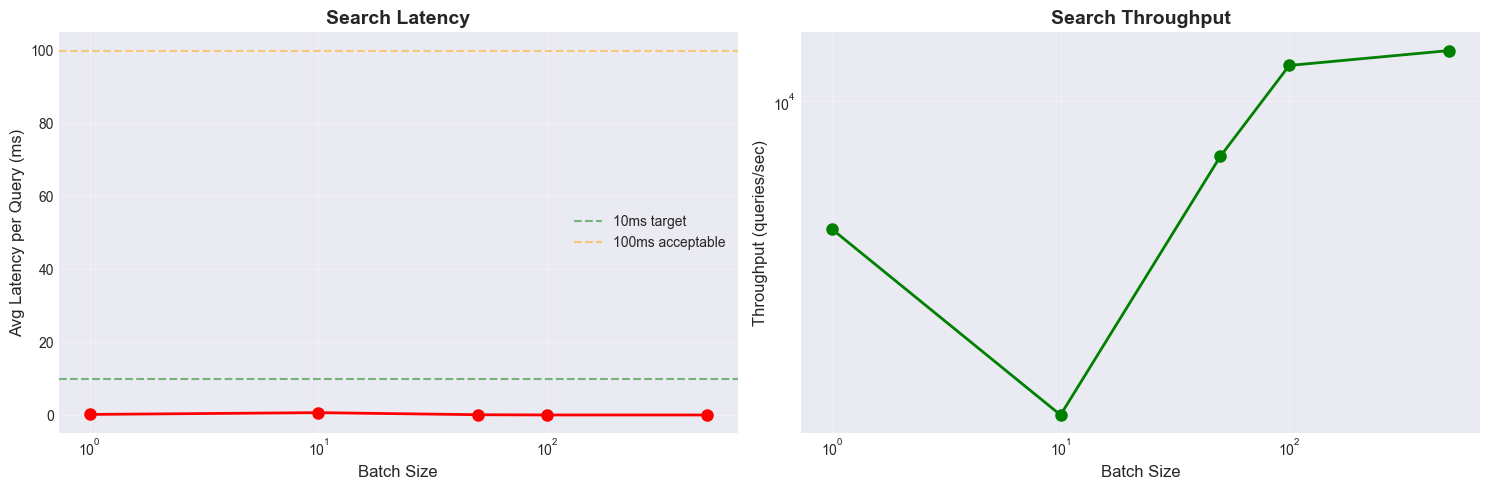

✓ Đã lưu: 06_production_performance.png


In [10]:
# Visualize performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Latency
ax1.plot(batch_sizes, latencies, 'o-', linewidth=2, markersize=8, color='red')
ax1.axhline(10, color='green', linestyle='--', alpha=0.5, label='10ms target')
ax1.axhline(100, color='orange', linestyle='--', alpha=0.5, label='100ms acceptable')
ax1.set_xlabel('Batch Size', fontsize=12)
ax1.set_ylabel('Avg Latency per Query (ms)', fontsize=12)
ax1.set_title('Search Latency', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Throughput
ax2.plot(batch_sizes, throughputs, 'o-', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Batch Size', fontsize=12)
ax2.set_ylabel('Throughput (queries/sec)', fontsize=12)
ax2.set_title('Search Throughput', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_production_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 06_production_performance.png")

## Production Best Practices Summary

In [11]:
print("="*80)
print("PRODUCTION BEST PRACTICES".center(80))
print("="*80)

print("""
🏗️ ARCHITECTURE:

1. Index Selection:
   • < 100K vectors: HNSW for best quality
   • 100K-1M: IVF or HNSW
   • > 1M: IVF+PQ for scale
   • > 10M: Distributed/sharded setup

2. Embedding Strategy:
   • Normalize for cosine similarity (IndexFlatIP)
   • Cache embeddings for frequently accessed items
   • Batch encode for efficiency

3. Serving Pattern:
   • Load index into memory at startup
   • Use connection pooling
   • Implement caching layer (Redis)
   • Monitor latency and set SLO (e.g., P95 < 50ms)

⚡ OPTIMIZATION:

1. Batching:
   • Batch similar requests together
   • Optimal batch size: 10-100 queries
   • Trade-off: latency vs throughput

2. Filtering:
   • Pre-filter by metadata before FAISS search
   • Post-filter results (price range, category, etc.)
   • Use IndexIDMap for filtering

3. Updates:
   • Rebuild index periodically (daily/weekly)
   • Use IndexIDMap2 for dynamic updates
   • Hot-swap indices with zero downtime

🔒 RELIABILITY:

1. Monitoring:
   • Track latency (P50, P95, P99)
   • Monitor recall quality
   • Alert on degradation

2. Fallback:
   • Have backup index type
   • Implement timeout and retry
   • Graceful degradation

3. A/B Testing:
   • Test different index types
   • Measure business metrics (CTR, conversions)
   • Iterate on parameters

💡 TIPS:

• Start simple (Flat/HNSW), optimize later
• Measure everything - don't guess
• User experience > raw metrics
• Consider cold start problem
• Plan for growth (10x headroom)

""")

print("="*80)
print(f"Current Setup Performance:")
print(f"  Index type: {index_type}")
print(f"  Products: {n_products:,}")
print(f"  Avg latency: {latencies[0]:.2f}ms")
print(f"  Throughput: {throughputs[-1]:.0f} queries/sec")
print(f"  Build time: {build_time:.2f}s")
print("="*80)

# Calculate estimated capacity
target_latency_ms = 50
estimated_qps = 1000 / latencies[0] if latencies[0] < target_latency_ms else 0
daily_queries = estimated_qps * 86400

print(f"\n📊 Estimated Capacity (P50 < {target_latency_ms}ms):")
print(f"  QPS: ~{estimated_qps:.0f}")
print(f"  Daily queries: ~{daily_queries:,.0f}")
print(f"  Monthly queries: ~{daily_queries * 30:,.0f}")

                           PRODUCTION BEST PRACTICES                            

🏗️ ARCHITECTURE:

1. Index Selection:
   • < 100K vectors: HNSW for best quality
   • 100K-1M: IVF or HNSW
   • > 1M: IVF+PQ for scale
   • > 10M: Distributed/sharded setup

2. Embedding Strategy:
   • Normalize for cosine similarity (IndexFlatIP)
   • Cache embeddings for frequently accessed items
   • Batch encode for efficiency

3. Serving Pattern:
   • Load index into memory at startup
   • Use connection pooling
   • Implement caching layer (Redis)
   • Monitor latency and set SLO (e.g., P95 < 50ms)

⚡ OPTIMIZATION:

1. Batching:
   • Batch similar requests together
   • Optimal batch size: 10-100 queries
   • Trade-off: latency vs throughput

2. Filtering:
   • Pre-filter by metadata before FAISS search
   • Post-filter results (price range, category, etc.)
   • Use IndexIDMap for filtering

3. Updates:
   • Rebuild index periodically (daily/weekly)
   • Use IndexIDMap2 for dynamic updates
   • Hot-

## Summary

In [12]:
print("\n" + "="*80)
print("✅ REAL-WORLD APPLICATION COMPLETE!")
print("="*80)

print("""
In this notebook, you learned:

✓ How to build a product recommendation system
✓ User-based recommendations from browsing history
✓ Production performance optimization
✓ Best practices for deploying FAISS
✓ Monitoring and reliability patterns

Next steps:
• Try with your own embeddings (CLIP, BERT, etc.)
• Implement filtering and business rules
• Build API service around FAISS
• Monitor and optimize for your use case
• Scale to millions of items

Happy building! 🚀
""")


✅ REAL-WORLD APPLICATION COMPLETE!

In this notebook, you learned:

✓ How to build a product recommendation system
✓ User-based recommendations from browsing history
✓ Production performance optimization
✓ Best practices for deploying FAISS
✓ Monitoring and reliability patterns

Next steps:
• Try with your own embeddings (CLIP, BERT, etc.)
• Implement filtering and business rules
• Build API service around FAISS
• Monitor and optimize for your use case
• Scale to millions of items

Happy building! 🚀

